## Librerias

In [1]:
import requests as req
import pandas as pd
import time
import selenium
import webdriver_manager
import numpy as np
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.common.by import By
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

from webdriver_manager.chrome import ChromeDriverManager


In [2]:
from selenium.webdriver.chrome.options import Options
# opciones del driver

opciones=Options()

# quita la bandera de ser robot
opciones.add_experimental_option('excludeSwitches', ['enable-automation'])
opciones.add_experimental_option('useAutomationExtension', False)

opciones.headless=False   # si True, no aparece la ventana (headless=no visible)

opciones.add_argument('--start-maximized')         # comienza maximizado

#opciones.add_extension('driver/adblock.crx')       # adblocker

opciones.add_argument('user-data-dir=selenium')    # mantiene las coockies


#opciones.add_argument('--incognito')              # incognito
 
#opciones.add_argument('--no-proxy-server')                 # sin proxy
#opciones.add_argument('proxy-server=106.122.8.54:3128')    # proxy custom

### CSV

In [3]:
nypd = pd.read_csv('../data/NYPD_Complaint_Data_Current__Year_To_Date_.csv')

In [4]:
nypd.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,New Georeferenced Column
0,261548672,43.0,BRONX,01/07/2023,21:30:00,NaN,(null),COMPLETED,(null),NaN,...,NaN,UNKNOWN,UNKNOWN,D,1026226.0,236504.0,40.815726,-73.848350,"(40.815726, -73.84835)",POINT (-73.84835 40.815726)
1,265065361,69.0,BROOKLYN,06/12/2022,01:55:00,NaN,(null),COMPLETED,(null),NaN,...,NaN,UNKNOWN,UNKNOWN,E,1012661.0,177364.0,40.653454,-73.897609,"(40.65345427, -73.89760855)",POINT (-73.89760855 40.65345427)
2,262612530,110.0,QUEENS,09/09/2022,00:55:00,09/09/2022,01:19:00,COMPLETED,(null),NaN,...,NaN,25-44,WHITE HISPANIC,F,1019164.0,210169.0,40.743481,-73.874004,"(40.7434812638841, -73.8740035373971)",POINT (-73.8740035373971 40.7434812638841)
3,261233867,123.0,STATEN ISLAND,01/02/2023,02:00:00,01/02/2023,02:10:00,COMPLETED,(null),NaN,...,NaN,45-64,WHITE,F,917367.0,125198.0,40.510063,-74.240524,"(40.510063, -74.240524)",POINT (-74.240524 40.510063)
4,264778583,30.0,MANHATTAN,06/29/2021,21:00:00,06/29/2021,21:30:00,COMPLETED,(null),NaN,...,NaN,25-44,WHITE,F,998164.0,241176.0,40.828637,-73.949722,"(40.828637, -73.949722)",POINT (-73.949722 40.828637)


### Me saco la explicación de cada columna 
soy una vaga y no quiero copiar y pegar

In [5]:
column_names = ['CMPLNT_NUM', 'ADDR_PCT_CD', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT', 
                'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT', 'HOUSING_PSA', 'JURISDICTION_CODE', 
                'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PARKS_NM', 'PATROL_BORO', 
                'PD_CD', 'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT', 'STATION_NAME', 'SUSP_AGE_GROUP', 'SUSP_RACE', 
                'SUSP_SEX', 'TRANSIT_DISTRICT', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'X_COORD_CD', 
                'Y_COORD_CD', 'Latitude', 'Longitude', 'Lat_Lon']

column_desc = ['Randomly generated persistent ID for each complaint',
 'The precinct in which the incident occurred',
 'The name of the borough in which the incident occurred',
 'Exact date of occurrence for the reported event (or starting date of occurrence, if CMPLNT_TO_DT exists)',
 'Exact time of occurrence for the reported event (or starting time of occurrence, if CMPLNT_TO_TM exists)',
 'Ending date of occurrence for the reported event, if exact time of occurrence is unknown',
 'Ending time of occurrence for the reported event, if exact time of occurrence is unknown',
 'Indicator of whether crime was successfully completed or attempted, but failed or was interrupted prematurely',
 'Name of NYCHA housing development of occurrence, if applicable',
 'Development Level Code',
 'Jurisdiction responsible for incident. Either internal, like Police(0), Transit(1), and Housing(2); or external(3), like Correction, Port Authority, etc.',
 'Description of the jurisdiction code',
 'Three digit offense classification code',
 'Level of offense: felony, misdemeanor, violation',
 'Specific location of occurrence in or around the premises; inside, opposite of, front of, rear of',
 'Description of offense corresponding with key code',
 'Name of NYC park, playground or greenspace of occurrence, if applicable (state parks are not included)',
 'The name of the patrol borough in which the incident occurred',
 'Three digit internal classification code (more granular than Key Code)',
 'Description of internal classification corresponding with PD code (more granular than Offense Description)',
 'Specific description of premises; grocery store, residence, street, etc.',
 'Date event was reported to police',
 'Transit station name',
 'Suspect’s Age Group',
 'Suspect’s Race Description',
 'Suspect’s Sex Description',
 'Transit district in which the offense occurred.',
 'Victim’s Age Group',
 'Victim’s Race Description',
 'Victim’s Sex Description',
 'X-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104)',
 'Y-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104)',
 'Midblock Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)',
 'Midblock Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)',
 'Location']




In [6]:


# Crear el dataframe
descripcion = pd.DataFrame()

descripcion['Nombre_Columna']=column_names
descripcion['Descripcion']=column_desc


descripcion

,Nombre_Columna,Descripcion
0,CMPLNT_NUM,Randomly generated persistent ID for each comp...
1,ADDR_PCT_CD,The precinct in which the incident occurred
2,BORO_NM,The name of the borough in which the incident ...
3,CMPLNT_FR_DT,Exact date of occurrence for the reported even...
4,CMPLNT_FR_TM,Exact time of occurrence for the reported even...
5,CMPLNT_TO_DT,Ending date of occurrence for the reported eve...
6,CMPLNT_TO_TM,Ending time of occurrence for the reported eve...
7,CRM_ATPT_CPTD_CD,Indicator of whether crime was successfully co...
8,HADEVELOPT,Name of NYCHA housing development of occurrenc...
9,HOUSING_PSA,Development Level Code


In [7]:
nans, cols, trim_cols = list(nypd.isnull().sum()), list(nypd.columns), list() 

In [8]:
    print(f"List of NAN counts in columns-\n {nans}\n")
    print(f"List of all attributes-\n {cols}\n")
    
    display_df = pd.DataFrame(np.column_stack([cols, nans]), columns=["colnames", "nan_counts"]) #print nans and cols together in a df
    display(display_df)

List of NAN counts in columns-
 [0, 14, 0, 0, 0, 9056, 0, 0, 0, 121418, 0, 0, 0, 0, 0, 0, 0, 0, 116, 0, 0, 0, 0, 0, 0, 0, 127040, 0, 0, 0, 1, 1, 1, 1, 1, 1]

List of all attributes-
 ['CMPLNT_NUM', 'ADDR_PCT_CD', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT', 'HOUSING_PSA', 'JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PARKS_NM', 'PATROL_BORO', 'PD_CD', 'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT', 'STATION_NAME', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'Lat_Lon', 'New Georeferenced Column']



,colnames,nan_counts
0,CMPLNT_NUM,0
1,ADDR_PCT_CD,14
2,BORO_NM,0
3,CMPLNT_FR_DT,0
4,CMPLNT_FR_TM,0
5,CMPLNT_TO_DT,9056
6,CMPLNT_TO_TM,0
7,CRM_ATPT_CPTD_CD,0
8,HADEVELOPT,0
9,HOUSING_PSA,121418


In [9]:
length_df, width_df = nypd.shape

trim_cols=[]

for i, nan_count in enumerate(nans): #for each nan_count in nans
    if (nan_count / length_df) > 0.5: #if ratio of length of df and number of nans in a column is > 0.5
        trim_cols.append(cols[i]) 
    
print(f"Columns identified for trimming- {trim_cols}\n")
    
nypd = nypd.drop(columns=trim_cols) #drop all columns present in the trim_cols list






Columns identified for trimming- ['HOUSING_PSA', 'TRANSIT_DISTRICT']



### Analisis de columnas sobrantes

CMPLNT_TO_DT Y CMPLNT_TO_TM que son 'Ending date of occurrence for the reported event, if exact time of occurrence is unknown',
 'Ending time of occurrence for the reported event, if exact time of occurrence is unknown', respectivamente las voy a eliminar ya que no me interesa fecha de inicio y fin.

 RPT_DT es redundante ya que también muestra el dia que el crimen fue reportado a la policia

'HADEVELOPT' me la cargo

'JURISDICTION_CODE',

 'JURIS_DESC'

'OFNS_DESC'


'PARKS_NM'


PATROL_BORO


'STATION_NAME'

'X_COORD_CD',


 'Y_COORD_CD'

 ADDR_PCT_CD

'CMPLNT_FR_TM'

KY_CD


 'PD_CD'

 'PD_DESC'

 'PREM_TYP_DESC'

 'Latitude', 'Longitude',
       'Lat_Lon'
 
 'CRM_ATPT_CPTD_CD'

 'SUSP_AGE_GROUP',
       'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'
 

In [10]:
nypd = nypd.drop(columns=['CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'RPT_DT', 'LOC_OF_OCCUR_DESC','HADEVELOPT','JURISDICTION_CODE', 'JURIS_DESC','OFNS_DESC', 'PARKS_NM','PATROL_BORO','STATION_NAME','X_COORD_CD', 'Y_COORD_CD','ADDR_PCT_CD','CMPLNT_FR_TM','KY_CD', 'PD_CD','PD_DESC','PREM_TYP_DESC',
       'Lat_Lon','CRM_ATPT_CPTD_CD','SUSP_AGE_GROUP',
       'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'])

In [11]:
nypd.columns

Index(['CMPLNT_NUM', 'BORO_NM', 'CMPLNT_FR_DT', 'LAW_CAT_CD', 'Latitude',
       'Longitude', 'New Georeferenced Column'],
      dtype='object')

Renombrar columnas

dfHplusY_retrim.rename(columns={
        'cmplnt_num':'ComplaintID', 
        'cmplnt_fr_dt':'Date',
        'cmplnt_fr_tm':'Time',
        'ky_cd':'Offence Code',
        'ofns_desc':'Description',
        'pd_cd':'Internal Code',
        'pd_desc':'Internal Description',
        'crm_atpt_cptd_cd':'Status',
        'law_cat_cd':'Offence Level',
        'boro_nm':'Borough',
        'addr_pct_cd':'Neighborhood',
        'prem_typ_desc':'Premise Description'}, inplace=True) #replace columns
    dfHplusY_retrim.reset_index(inplace=True) #reset index 

In [12]:
nypd.rename(columns={
        'CMPLNT_NUM':'ComplaintID', 
        'ADDR_PCT_CD':'Neighborhood',
        'BORO_NM':'Borough',
        'CMPLNT_FR_DT':'Date',
        'CMPLNT_FR_TM':'Time',
        'KY_CD':'Offence Code',
        'OFNS_DESC':'Description',
        'PD_CD':'Internal Code',
        'PD_DESC':'Internal Description',
        'CRM_ATPT_CPTD_CD':'Crime_Attempt',
        'LAW_CAT_CD':'Offence_Level',
        'PREM_TYP_DESC':'Premise_Description',
        'SUSP_AGE_GROUP':'Suspect_Age',
        'SUSP_RACE':'Suspect_Race',
        'SUSP_SEX':'Suspect_Sex',
        'VIC_AGE_GROUP':'Victim_Age',
        'VIC_RACE':'Victim_Race',
        'VIC_SEX':'Victim_Sex',

        }, inplace=True) #replace columns


In [13]:
nypd.columns

Index(['ComplaintID', 'Borough', 'Date', 'Offence_Level', 'Latitude',
       'Longitude', 'New Georeferenced Column'],
      dtype='object')

In [14]:
nypd.shape

(130199, 7)

Saco el año y el mes

In [15]:
nypd['Year'] = nypd.Date.str[6:] #get first four values of Date.string
nypd['Month'] = nypd.Date.str[:2] #get the next 3 values of Date.string 

In [16]:
nypd.head()

,ComplaintID,Borough,Date,Offence_Level,Latitude,Longitude,New Georeferenced Column,Year,Month
0,261548672,BRONX,01/07/2023,FELONY,40.815726,-73.848350,POINT (-73.84835 40.815726),2023,01
1,265065361,BROOKLYN,06/12/2022,FELONY,40.653454,-73.897609,POINT (-73.89760855 40.65345427),2022,06
2,262612530,QUEENS,09/09/2022,VIOLATION,40.743481,-73.874004,POINT (-73.8740035373971 40.7434812638841),2022,09
3,261233867,STATEN ISLAND,01/02/2023,MISDEMEANOR,40.510063,-74.240524,POINT (-74.240524 40.510063),2023,01
4,264778583,MANHATTAN,06/29/2021,MISDEMEANOR,40.828637,-73.949722,POINT (-73.949722 40.828637),2021,06


Transformar la columna Month

In [17]:
mes_dic = {
    "01": "January",
    "02": "February",
    "03": "March",
    "04": "April",
    "05": "May",
    "06": "June",
    "07": "July",
    "08": "August",
    "09": "September",
    "10": "October",
    "11": "November",
    "12": "December"
}

nypd['Month'] = nypd['Month'].map(mes_dic)


In [18]:
nypd.head()

,ComplaintID,Borough,Date,Offence_Level,Latitude,Longitude,New Georeferenced Column,Year,Month
0,261548672,BRONX,01/07/2023,FELONY,40.815726,-73.848350,POINT (-73.84835 40.815726),2023,January
1,265065361,BROOKLYN,06/12/2022,FELONY,40.653454,-73.897609,POINT (-73.89760855 40.65345427),2022,June
2,262612530,QUEENS,09/09/2022,VIOLATION,40.743481,-73.874004,POINT (-73.8740035373971 40.7434812638841),2022,September
3,261233867,STATEN ISLAND,01/02/2023,MISDEMEANOR,40.510063,-74.240524,POINT (-74.240524 40.510063),2023,January
4,264778583,MANHATTAN,06/29/2021,MISDEMEANOR,40.828637,-73.949722,POINT (-73.949722 40.828637),2021,June


In [19]:
nypd['Borough']

0                 BRONX
1              BROOKLYN
2                QUEENS
3         STATEN ISLAND
4             MANHATTAN
              ...      
130194         BROOKLYN
130195        MANHATTAN
130196        MANHATTAN
130197            BRONX
130198           QUEENS
Name: Borough, Length: 130199, dtype: object

In [20]:
borough_title = list(map(lambda x: x.title(), list(nypd['Borough'])))
nypd['Borough'] = borough_title

In [21]:
nypd.head()

,ComplaintID,Borough,Date,Offence_Level,Latitude,Longitude,New Georeferenced Column,Year,Month
0,261548672,Bronx,01/07/2023,FELONY,40.815726,-73.848350,POINT (-73.84835 40.815726),2023,January
1,265065361,Brooklyn,06/12/2022,FELONY,40.653454,-73.897609,POINT (-73.89760855 40.65345427),2022,June
2,262612530,Queens,09/09/2022,VIOLATION,40.743481,-73.874004,POINT (-73.8740035373971 40.7434812638841),2022,September
3,261233867,Staten Island,01/02/2023,MISDEMEANOR,40.510063,-74.240524,POINT (-74.240524 40.510063),2023,January
4,264778583,Manhattan,06/29/2021,MISDEMEANOR,40.828637,-73.949722,POINT (-73.949722 40.828637),2021,June


In [22]:
nypd.Borough.unique()

array(['Bronx', 'Brooklyn', 'Queens', 'Staten Island', 'Manhattan',
       '(Null)'], dtype=object)

In [23]:
nypd = nypd.dropna()

In [24]:
nypd

,ComplaintID,Borough,Date,Offence_Level,Latitude,Longitude,New Georeferenced Column,Year,Month
0,261548672,Bronx,01/07/2023,FELONY,40.815726,-73.848350,POINT (-73.84835 40.815726),2023,January
1,265065361,Brooklyn,06/12/2022,FELONY,40.653454,-73.897609,POINT (-73.89760855 40.65345427),2022,June
2,262612530,Queens,09/09/2022,VIOLATION,40.743481,-73.874004,POINT (-73.8740035373971 40.7434812638841),2022,September
3,261233867,Staten Island,01/02/2023,MISDEMEANOR,40.510063,-74.240524,POINT (-74.240524 40.510063),2023,January
4,264778583,Manhattan,06/29/2021,MISDEMEANOR,40.828637,-73.949722,POINT (-73.949722 40.828637),2021,June
...,...,...,...,...,...,...,...,...,...
130194,265938590,Brooklyn,03/30/2023,FELONY,40.696872,-73.923024,POINT (-73.92302388 40.69687174),2023,March
130195,265988197,Manhattan,03/31/2023,VIOLATION,40.710887,-74.009061,POINT (-74.00906088 40.71088719),2023,March
130196,265966526,Manhattan,03/31/2023,MISDEMEANOR,40.718009,-73.989853,POINT (-73.989853 40.718009),2023,March
130197,265958921,Bronx,03/31/2023,MISDEMEANOR,40.844238,-73.877673,POINT (-73.877673 40.844238),2023,March


In [25]:
#nypd.to_csv('historic_crime.csv', index=False)

In [26]:
nypd.drop(nypd[nypd['Borough'] == '(Null)'].index, inplace=True)

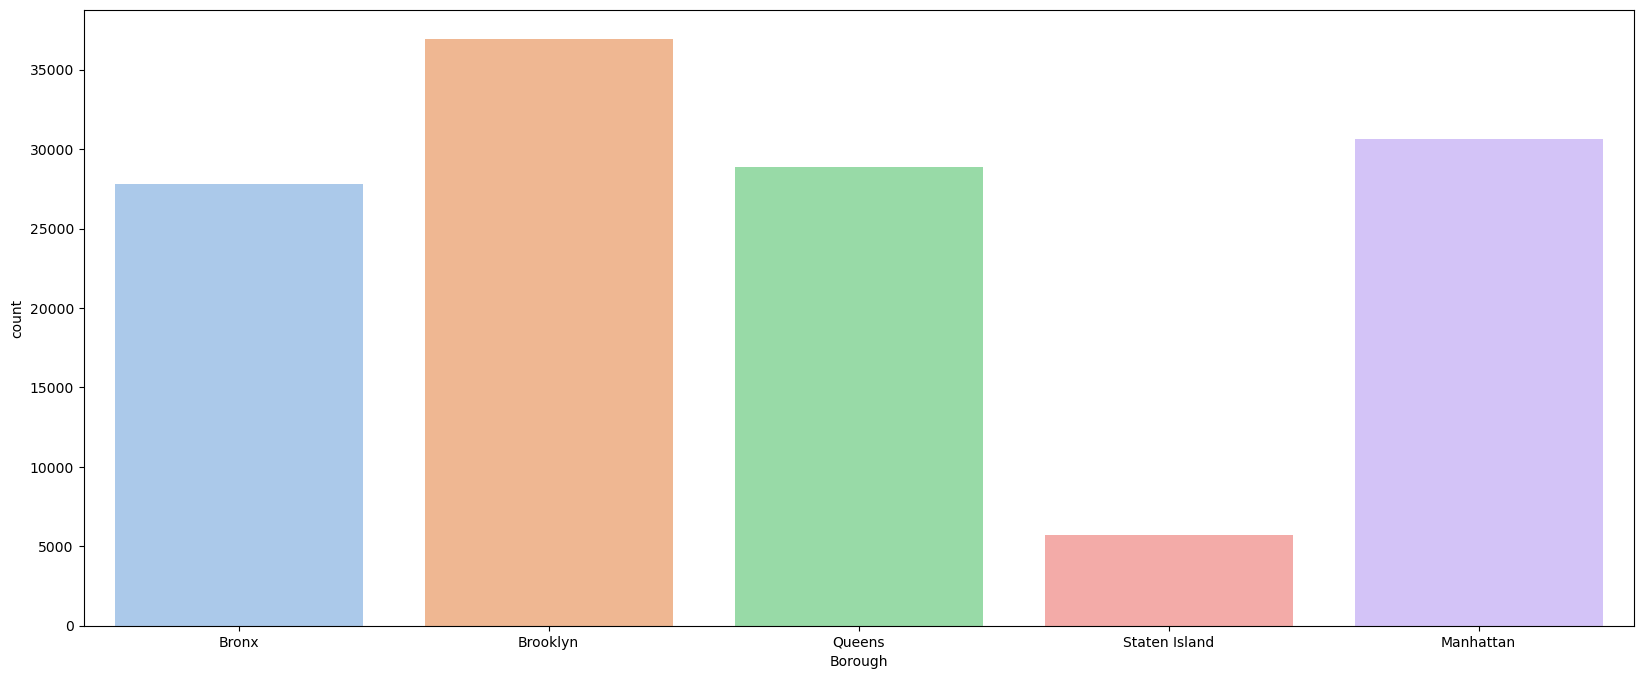

In [27]:
f, ax = plt.subplots(figsize=(20, 8))
sns.countplot(x="Borough", data=nypd, palette="pastel");

Con folium genero el mapa interactivo,

Nueva York se encuentra en la latitud 40.71427 y longitud -74.00597. 

Mapa de calor a partir de latitud y longitud.
'Stamen Terrain': es el estilo de los mapas de Folium que es un mapa topográfico con relieve.


El mapa de calor muestra la distribución de los incidentes de disparos en la ciudad de Nueva York. Los puntos más intensos representan las áreas donde se han reportado más incidentes de disparos, mientras que los puntos menos intensos representan las áreas donde se han reportado menos incidentes.


In [28]:
positions = list(zip(nypd['Latitude'], nypd['Longitude']))
tiles = 'Stamen Terrain'
fol = folium.Map(location=[40.71,-74.00], zoom_start=9.4, tiles = tiles)
HeatMap(positions, radius = 8).add_to(fol) 
fol

In [30]:
fol.save('pics/map.html')

FileNotFoundError: [Errno 2] No such file or directory: 'pics/map.html'